## Check combining files

This to check that individual files on ceda server are combined into a single dataset properly.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings('ignore')

### Check for mean drift data

In [3]:
ppdir1="/home/users/hkhatri/DePreSys4_Data/Data_Drift_Removal/Drift_2016_DCPP/"

var = 'tos'

ds_drift = []
    
for lead_year in range(0, 11):
    
    ds1 =[]
    
    for r in range(1,11):
    
        d = xr.open_dataset(ppdir1 + "Drift_" + var + "_r" + str(r) + "_Lead_Year_" + str(lead_year + 1) + ".nc", decode_times= False)
        ds1.append(d)
        
    ds1 = xr.concat(ds1, dim='r')
    
    ds_drift.append(ds1)
        
ds_drift = xr.concat(ds_drift, dim='lead_year')

In [4]:
print(ds_drift)

<xarray.Dataset>
Dimensions:    (i: 450, j: 450, lead_year: 11, r: 10)
Coordinates:
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    longitude  (j, i) float32 -99.75 -99.5 -99.25 -99.0 ... 51.08 51.24 51.41
    latitude   (j, i) float32 3.997 3.997 3.997 3.997 ... 73.44 73.34 73.24
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
Dimensions without coordinates: lead_year, r
Data variables:
    tos        (lead_year, r, j, i) float32 27.35 27.36 27.38 ... -0.7296 -1.264


### Check for full data

In [10]:
ppdir="/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/"

ds = []

for year in range(2011, 2013, 1):

    ds1 = []

    for i in range(0,4):
        
        var_path = "s" + str(year) +"-r" + str(i+1) + "i1p1f2/Omon/" + var + "/gn/files/d20200417/"
        d = xr.open_mfdataset(ppdir + var_path + "*.nc")
        ds1.append(d)
        
    ds1 = xr.concat(ds1, dim='r')
    ds1['time_val'] = d['time'] # dropping time coordinate is required; otherwise xarray concat does not work properly
    ds1 = ds1.drop(['time', 'vertices_latitude', 'vertices_longitude', 'time_bnds'])
    
    ds.append(ds1)
    
ds = xr.concat(ds, dim='year')

In [11]:
print(ds)

<xarray.Dataset>
Dimensions:    (j: 1205, i: 1440, year: 2, r: 4, time: 125)
Coordinates:
  * j          (j) int32 0 1 2 3 4 5 6 7 ... 1198 1199 1200 1201 1202 1203 1204
  * i          (i) int32 0 1 2 3 4 5 6 7 ... 1433 1434 1435 1436 1437 1438 1439
    latitude   (j, i) float32 -89.49 -89.49 -89.49 -89.49 ... 50.07 50.02 50.0
    longitude  (j, i) float32 73.0 73.25 73.5 73.75 74.0 ... 73.0 73.0 73.0 73.0
Dimensions without coordinates: year, r, time
Data variables:
    tos        (year, r, time, j, i) float32 dask.array<chunksize=(1, 1, 2, 1205, 1440), meta=np.ndarray>
    time_val   (year, time) object 2011-11-16 00:00:00 ... 2023-03-16 00:00:00
Attributes: (12/43)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DCPP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2021-03-01T23:49:13Z
    ...                     ...
    tracking_id:            hdl:21.14100/d32fb72f-7f99-4f9d-a1b

### Compute DJF seasonal anomaly 

In [24]:
ds = ds.assign_coords(time=ds['time_val'].isel(year=0)) # this is just to get seasonal averaging work
ds = ds.isel(i=slice(749,1199), j = slice(699, 1149))

tos_resam = ds['tos'].resample(time='QS-DEC').mean('time')
tos_resam = tos_resam.sel(time = tos_resam['time.season'] == 'DJF')

# again drop time and change names to be consistent with ds_drift
tos_resam = tos_resam.drop('time')
tos = tos_resam.rename({'time':'lead_year'})

tos = tos.transpose('year','lead_year','r','j','i')

In [25]:
print(tos)

<xarray.DataArray 'tos' (year: 2, lead_year: 11, r: 4, j: 450, i: 450)>
dask.array<transpose, shape=(2, 11, 4, 450, 450), dtype=float32, chunksize=(1, 1, 1, 450, 450), chunktype=numpy.ndarray>
Coordinates:
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 3.997 3.997 3.997 3.997 ... 73.44 73.34 73.24
    longitude  (j, i) float32 -99.75 -99.5 -99.25 -99.0 ... 51.08 51.24 51.41
Dimensions without coordinates: year, lead_year, r


In [27]:
tos_anom = tos - ds_drift['tos'].isel(r=slice(0,4))

print(tos_anom)

<xarray.DataArray 'tos' (year: 2, lead_year: 11, r: 4, j: 450, i: 450)>
dask.array<sub, shape=(2, 11, 4, 450, 450), dtype=float32, chunksize=(1, 1, 1, 450, 450), chunktype=numpy.ndarray>
Coordinates:
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 3.997 3.997 3.997 3.997 ... 73.44 73.34 73.24
    longitude  (j, i) float32 -99.75 -99.5 -99.25 -99.0 ... 51.08 51.24 51.41
Dimensions without coordinates: year, lead_year, r


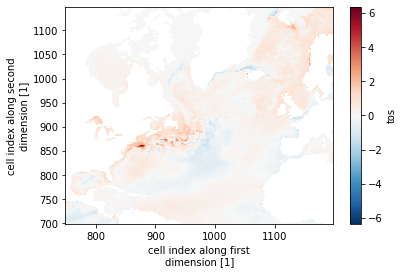

In [28]:
tos_anom.isel(year=0, r=0, lead_year=0).plot()